In [2]:
import numpy as np
from scipy.special import digamma

def generate_network_data(n_normal=950, n_anomaly=50, random_state=42) :
    """ Generuje dane ruchu sieciowego z anomaliami ."""
    np.random.seed(random_state)
    # Normalny ruch - 3 klastry operacyjne
    normal = np.vstack([
        np.random.randn(n_normal // 3, 4) * 0.5 + [50, 100, 0.8, 30],
        np.random.randn(n_normal // 3, 4) * 0.5 + [55, 110, 0.75, 35],
        np.random.randn(n_normal // 3, 4) * 0.5 + [48, 95, 0.85, 28],
    ])
    # Anomalie - rozne wzorce atakow
    anomalies = np.vstack([
        np.random.randn(n_anomaly // 2, 4) * 0.3 + [200, 500, 0.1, 5], # DDoS
        np.random.randn(n_anomaly // 2, 4) * 0.3 + [10, 10, 0.99, 100], # Port scan
    ])
    X = np.vstack([normal, anomalies])
    y = np.array([0] * len(normal) + [1] * len(anomalies))
    return X, y


class IsolationTree:
    """ Pojedyncze drzewo izolujace ."""
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, current_depth=0):
        if current_depth == 0:
            self.root = self._build_tree(X, current_depth)
            return self
        else:
            return self._build_tree(X, current_depth)
    
    def _build_tree(self, X, current_depth):
        """ Buduje drzewo z losowymi podzialami ( bez etykiet !)."""
        n_samples, n_features = X.shape

        # Warunek stopu
        if n_samples <= 1 or (self.max_depth and current_depth >= self.max_depth):
            return {
                'type': 'leaf', 
                'size': n_samples, 
                'depth': current_depth
            }
        
        # Losuj ceche i prog
        feature = np.random.randint(0, n_features)
        min_val, max_val = X[:, feature].min(), X[:, feature].max()
        threshold = np.random.uniform(min_val, max_val)

        # Podziel dane i rekurencyjnie buduj poddrzewa
        mask_left = X[:, feature] < threshold
        mask_right = X[:, feature] >= threshold
        X_left = X[mask_left]
        X_right = X[mask_right]
        
        return {
            'type': 'node',
            'feature': feature,
            'threshold': threshold,
            'left': self._build_tree(X_left, current_depth + 1),
            'right': self._build_tree(X_right, current_depth + 1)
        }
    def path_length(self, x, node=None, current_depth=0) :
        """ Oblicza glebokosc izolacji punktu x."""
        if node is None:
            node = self.root

        if node['type'] == 'leaf':
            return current_depth
        
        feature_id = node['feature']
        threshold = node['threshold']
        if x[feature_id] < threshold:
            return self.path_length(x, node['left'], current_depth + 1)
        else:
            return self.path_length(x, node['right'], current_depth + 1) 


def c_factor(n):
    """ Oblicza oczekiwana glebokosc BST dla n elementow ."""
    if n <= 1:
        return 0
    return 2 * (np.log(n - 1) + 0.5772156649) - 2 * (n - 1) / n


def anomaly_score(path_lengths, n_samples):
    """ Oblicza znormalizowany anomaly score ."""
    c = c_factor(n_samples)
    return 2 ** (-np.array(path_lengths) / c)

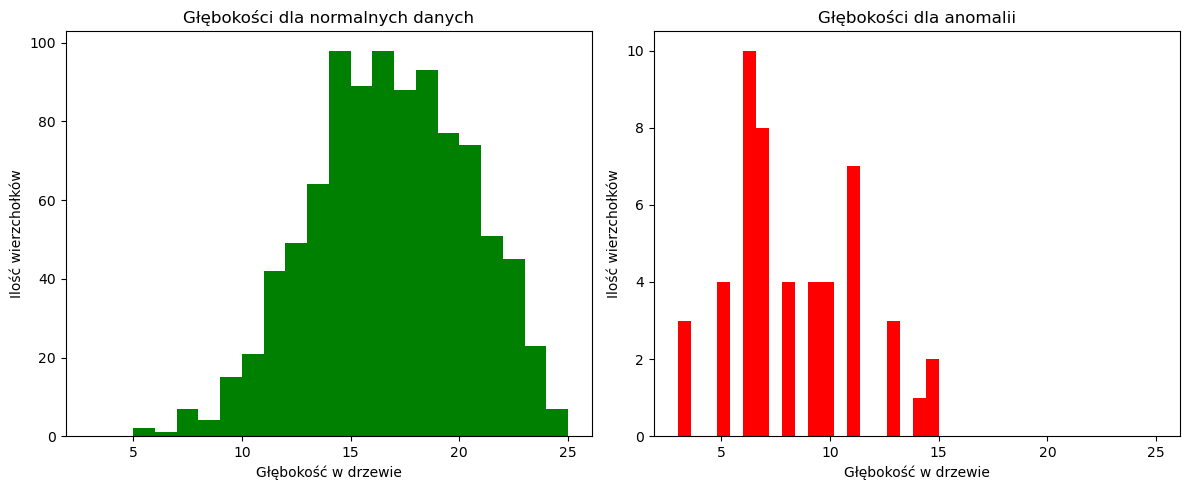

In [3]:
# Histogram głębokości w drzewie
import matplotlib.pyplot as plt

X, y = generate_network_data()

tree = IsolationTree()
tree.fit(X)

X_normal = [x for i, x in enumerate(X) if y[i] == 0]
y_normal = [tree.path_length(x) for x in X_normal]
X_anomaly = [x for i, x in enumerate(X) if y[i] == 1]
y_anomaly = [tree.path_length(x) for x in X_anomaly]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True, sharex=True, sharey=False)
axes[0].set_title("Głębokości dla normalnych danych")
axes[0].hist(y_normal, bins=20, color='green')
axes[0].set_xlabel("Głębokość w drzewie")
axes[0].set_ylabel("Ilość wierzchołków")

axes[1].set_title("Głębokości dla anomalii")
axes[1].hist(y_anomaly, bins=20, color='red')
axes[1].set_xlabel("Głębokość w drzewie")
axes[1].set_ylabel("Ilość wierzchołków")

plt.show()

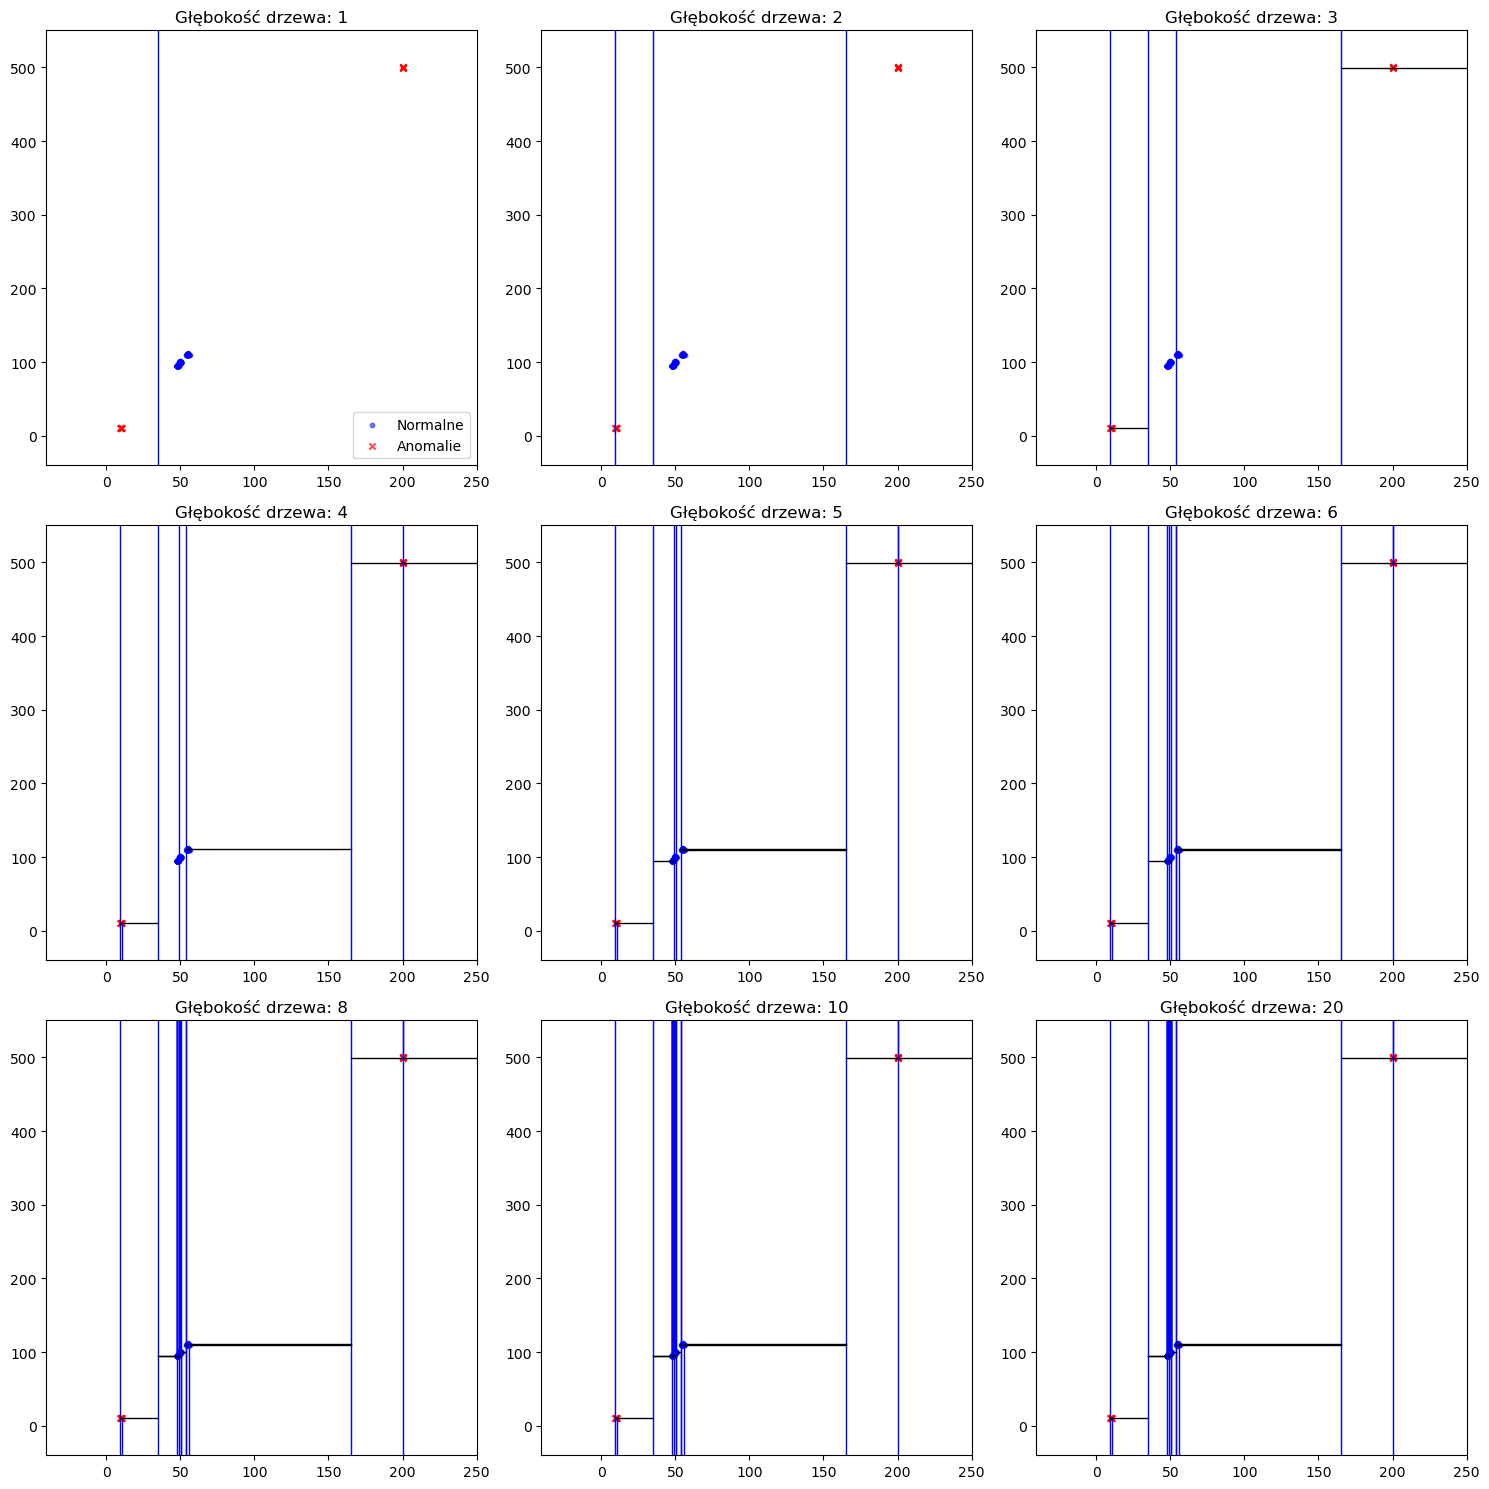

In [4]:
# Podpunkt b
X, y = generate_network_data(n_normal=90, n_anomaly=10)
X_2d = X[:, :2]

def plot_tree_splits(ax, node, bounds, current_depth, max_depth_to_plot):
    if node['type'] == 'leaf' or current_depth >= max_depth_to_plot:
        return
    
    feature = node['feature']
    threshold = node['threshold']
    x_min, x_max, y_min, y_max = bounds

    if feature == 0: 
        ax.plot([threshold, threshold], [y_min, y_max], color='blue', linewidth=1)
        plot_tree_splits(ax, node['left'], (x_min, threshold, y_min, y_max), current_depth + 1, max_depth_to_plot)
        plot_tree_splits(ax, node['right'], (threshold, x_max, y_min, y_max), current_depth + 1, max_depth_to_plot)
    else:
        ax.plot([x_min, x_max], [threshold, threshold], color='black', linewidth=1)
        plot_tree_splits(ax, node['left'], (x_min, x_max, y_min, threshold), current_depth + 1, max_depth_to_plot)
        plot_tree_splits(ax, node['right'], (x_min, x_max, threshold, y_max), current_depth + 1, max_depth_to_plot)
    

depths_to_show = [1, 2, 3, 4, 5, 6, 8, 10, 20]

tree = IsolationTree(max_depth=20)
tree.fit(X_2d)

n_plots = len(depths_to_show)
cols = 3
rows = (n_plots + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

x_min, x_max = X[:, 0].min() - 50, X[:, 0].max() + 50
y_min, y_max = X[:, 1].min() - 50, X[:, 1].max() + 50
init_bounds = (x_min, x_max, y_min, y_max)

for i, depth in enumerate(depths_to_show):
    ax = axes[i]

    ax.scatter(X[y==0, 0], X[y==0, 1], c='blue', s=10, alpha=0.5, label='Normalne')
    ax.scatter(X[y==1, 0], X[y==1, 1], c='red', s=20, alpha=0.7, label='Anomalie', marker="x")

    plot_tree_splits(ax, tree.root, init_bounds, 0, depth)

    ax.set_title(f"Głębokość drzewa: {depth}")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

In [5]:
# Podpunkt c
def Isolation_tree_predicter(n_trees, X_train, X_test, threshold, max_samples):
    n_samples = X_train.shape[0]
    sample_size = min(max_samples, n_samples)
    all_paths = []

    for _ in range(n_trees):
        indices = np.random.choice(n_samples, sample_size, replace=False)
        X_train_sub = X_train[indices]
        tree = IsolationTree()
        tree.fit(X_train_sub)

        paths = [tree.path_length(x) for x in X_test]
        all_paths.append(paths)

    mean_paths = np.array(all_paths).mean(axis=0)
    normalized_paths = anomaly_score(mean_paths, len(X_test))
    predicts = [1 if normalized_paths[i] > threshold else 0 for i in range(len(normalized_paths))]
    
    return predicts



In [17]:
# Podpunkt d
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.neighbors import LocalOutlierFactor

X, y = generate_network_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=42)

# LOF
lof = LocalOutlierFactor(n_neighbors=150, novelty=True)
lof.fit(X_train, y_train)
lof_pred = lof.predict(X_test)
lof_pred = [1 if p == -1 else 0 for p in lof_pred]
print("=" * 50)
print("LOF: ")
# print(classification_report(y_test, lof_pred))
print(f1_score(y_test, lof_pred))

# One Class SVM
from sklearn.svm import SVC

svc = SVC(kernel='rbf', C=1.0, gamma=0.5)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
print("=" * 50)
print("SVC: ")
#print(classification_report(y_test, svc_pred))
print(f1_score(y_test, svc_pred))

# Isolation Forest simulation
from itertools import product

print("=" * 50)
n_trees = [50, 100, 200]
max_samples = [64, 128, 256, 512]
for (n_t, m_samples) in product(n_trees, max_samples):
    forest_pred = Isolation_tree_predicter(n_t, X_train, X_test, 0.5, m_samples)
    print(f"Las złożony z {n_t} drzew oraz dzielący dane subsety o wielkości: {m_samples}")
    print(f"F1-Score: {f1_score(y_test, forest_pred)}") 

# Sklearn isolation forrest
from sklearn.ensemble import IsolationForest

sklearn_if = IsolationForest(n_estimators=100, contamination=np.mean(y_test), random_state=42)
sklearn_if.fit(X_train, y_train)
sif_pred = sklearn_if.predict(X_test)
sif_pred = [1 if p == -1 else 0 for p in sif_pred]
print("=" * 50)
print("Sklearn Isolation Forrest: ")
# print(classification_report(y_test, sif_pred))
print(f"F1-score: {f1_score(y_test, sif_pred)}")



LOF: 
1.0
SVC: 
1.0
Las złożony z 50 drzew oraz dzielący dane subsety o wielkości: 64
F1-Score: 0.1015625
Las złożony z 50 drzew oraz dzielący dane subsety o wielkości: 128
F1-Score: 0.24299065420560748
Las złożony z 50 drzew oraz dzielący dane subsety o wielkości: 256
F1-Score: 0.6341463414634146
Las złożony z 50 drzew oraz dzielący dane subsety o wielkości: 512
F1-Score: 0.9285714285714286
Las złożony z 100 drzew oraz dzielący dane subsety o wielkości: 64
F1-Score: 0.10276679841897234
Las złożony z 100 drzew oraz dzielący dane subsety o wielkości: 128
F1-Score: 0.23214285714285715
Las złożony z 100 drzew oraz dzielący dane subsety o wielkości: 256
F1-Score: 0.65
Las złożony z 100 drzew oraz dzielący dane subsety o wielkości: 512
F1-Score: 0.9285714285714286
Las złożony z 200 drzew oraz dzielący dane subsety o wielkości: 64
F1-Score: 0.10116731517509728
Las złożony z 200 drzew oraz dzielący dane subsety o wielkości: 128
F1-Score: 0.24761904761904763
Las złożony z 200 drzew oraz dzielą